In [1]:
import Plots
using DSP
using Random
using FFTW
using Statistics
using Distributions
using EasyFit
using LsqFit
using StatsBase
using NFFT

In [2]:
import Pkg
Pkg.add("StatsBase")



    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [3]:
function draw_image(h, w; mode = nothing, save_fn = nothing)
    print("Its me! 1")
    image = zeros(h, w)

    if mode == "blobs"
        Threads.@threads for y in range(1, h)
            y_scale = y / h
            # print(y_scale)
            for x in range(1, w)
                x_scale = x / w
                
                mu_x = 0.5 - 0.2 * y_scale; sigma_x = 0.1
                mu_y = 0.5; sigma_y = 0.2
                image[y, x] += exp(-0.5 * ((x_scale - mu_x)/ sigma_x)^2) * exp(-0.5 * ((y_scale - mu_y)/ sigma_y)^2)
                
                mu_x = 0.9 - 0.15 * y_scale; sigma_x = 0.04
                mu_y = 0.7; sigma_y = 0.03
                image[y, x] += exp(-0.5 * ((x_scale - mu_x)/ sigma_x)^2) * exp(-0.5 * ((y_scale - mu_y)/ sigma_y)^2)
            end 
        end
    else  
        Threads.@threads for y in range(1, h)
            y_scale = y / h
            # print(y_scale)
            for x in range(1, w)
                x_scale = x / w

                mu_exp = 0.5 + (6 * y_scale^2 - 8 * y_scale^3 - 0.5) * 0.3
                sigma_exp = 0.13 * (1 - y_scale)^2


                # pref = 1 / (sqrt( 2 * pi) * sigma_exp)

                image[y, x] = exp(-0.5 * ((x_scale - mu_exp)/ sigma_exp)^2) #  .* pref 

                freqo_x = 0.8 * (1 - y_scale^2)
                freqo_y = 0.4 * (1 - y_scale^2)

                image[y, x] *= 5.0 + sin(x_scale * 100 * freqo_x)^2
                image[y, x] *= 5.0 + sin(y_scale * 100 * freqo_y)^2

                tan_set = x_scale * 0.9

                # image[y, x] +=  200 * atan(x_scale - 10)
            end 
        end 
    end
    
    if save_fn != nothing 
        Plots.saveim(image, string(save_fn))
    end 
        
    return image
end
    
function add_noise(image::Array, noise_factor; random_mode="normal", random_seed=93)
    println("Here I am! 1")
    rng = MersenneTwister(Int(random_seed))   
    mean_of_image = sum(abs.(image)) / length(image)
    println(length(image))
    println(size(image))
    println(mean_of_image)
        
    new_image = zeros(size(image))
            
    if random_mode == "normal"
        new_image .+= image .+ mean_of_image * noise_factor * randn(rng, size(image))
    elseif random_mode == "uniform"
        new_image .+= image .+ mean_of_image * noise_factor * rand(rng, size(image))
    elseif random_mode == "ricean"
        a = 1
    end 
            
            
    return new_image 
end 

function masker(fft_image; thres=3, mode=nothing, verbose=false)
    if verbose == true
        println("Its the maskenball!!!")
    end
    fft_size = size(fft_image)
    mask = abs.(fft_image)
    mean_mask = mean(mask)
    thres_mask =  thres * stdm(mask, mean_mask) + mean_mask
    
    if mode == "thres"
        if verbose == true
            println("Mode: Threshold")
        end
        Threads.@threads for i in eachindex(mask)
            if mask[i] < thres_mask
                mask[i] = 0
            end 
        end 
    else
        if verbose == true
            println("Modus: Quadrierung")
        end
        mask = mask.^(1.3)
    end
    
    # signal = abs.fft_image[1:10, 1:10]
    return mask
end 
    
function remove_noise(fft_image, mask, window)
    denoised_image = zeros(size(fft_image))
    
    im_angles = im * angle.(fft_image)
    abs_fft_image = abs.(fft_image)
    filtered_fft_image = abs_fft_image .* mask .* exp.(im_angles)
    
    denoised_image = abs.(ifft(filtered_fft_image))
    return denoised_image
end
    
    

remove_noise (generic function with 1 method)

In [4]:
height = 200
width = 300
apollon = draw_image(height, width)

println(4 + im)

Its me! 14 + 1im


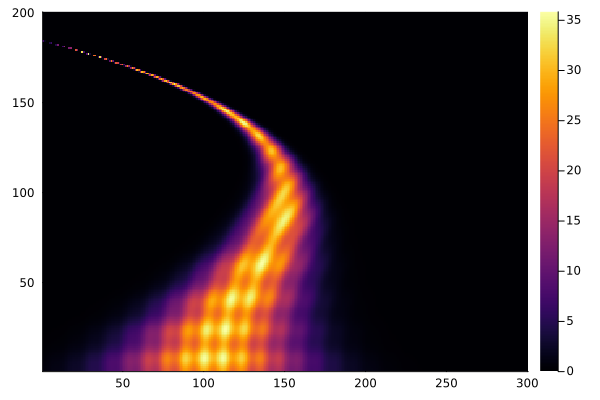

In [5]:
Plots.heatmap(apollon)

In [6]:
noisy_apollon = add_noise(apollon, 4.0); a = 1

Here I am! 1
60000
(200, 300)
3.2567562648654005


1

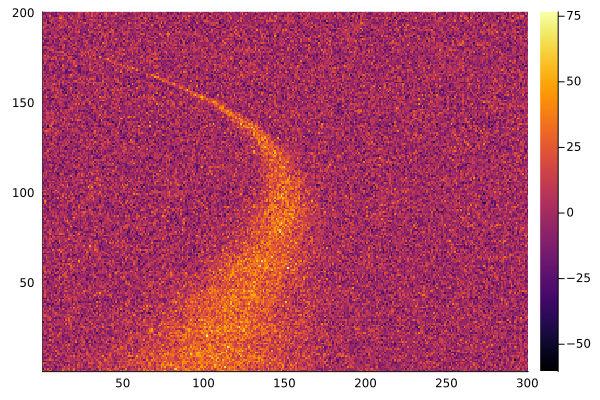

In [7]:
Plots.heatmap(noisy_apollon)

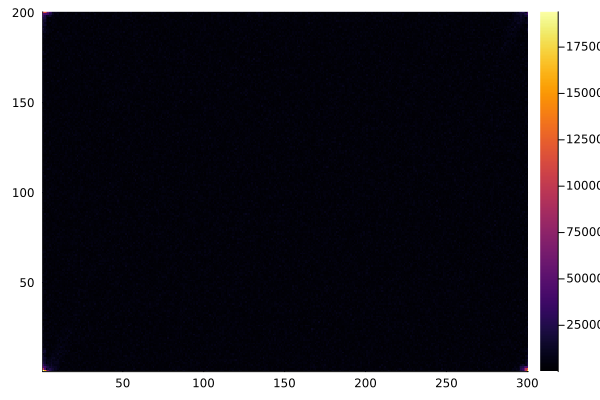

In [12]:
cutter1 = 40
cutter2 = 40


# window_2d = DSP.Windows.hanning(size(noisy_apollon))
# window_2d_inv = 1 ./ window_2d 
window_2d = ones(size(noisy_apollon))
grandpa = fft( window_2d .* noisy_apollon)

Plots.heatmap(abs.(grandpa))

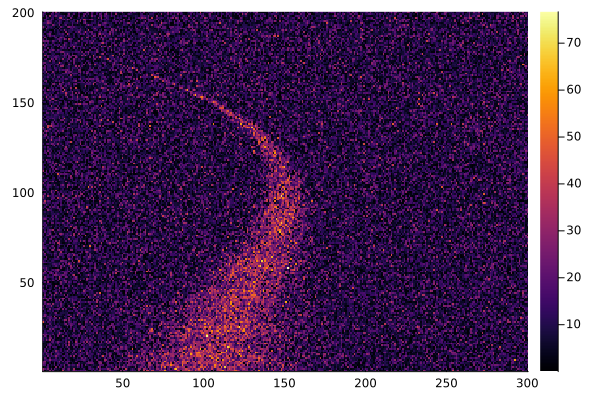

In [13]:
Plots.heatmap(abs.(ifft(grandpa)))

In [213]:
print(length(grandpa_hist.edges[1]))


9702

In [214]:
print(length(grandpa_hist.weights))

9701

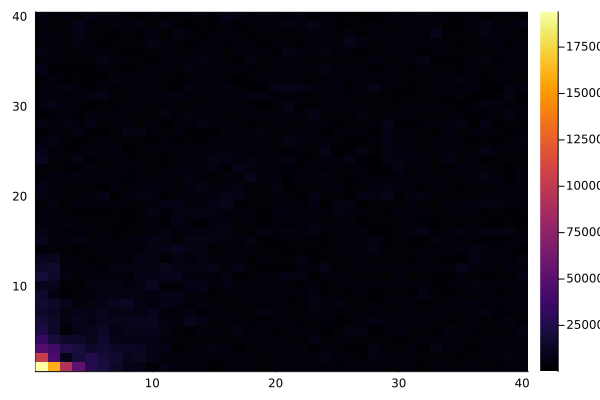

In [13]:
Plots.heatmap(abs.(granny))

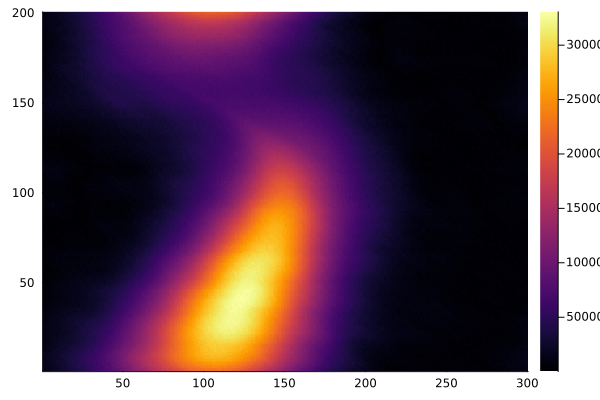

In [10]:
my_mask = masker(grandpa, thres=2.0, mode="thres")
ready = remove_noise(grandpa, my_mask, window_2d)
Plots.heatmap(ready)

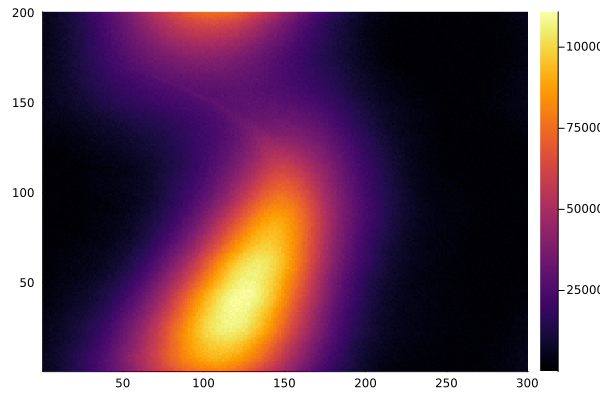

In [11]:
my_mask2 = masker(grandpa)
ready2 = remove_noise(grandpa, my_mask2, window_2d)
Plots.heatmap(ready2)

attempt to save state beyond implementation limit


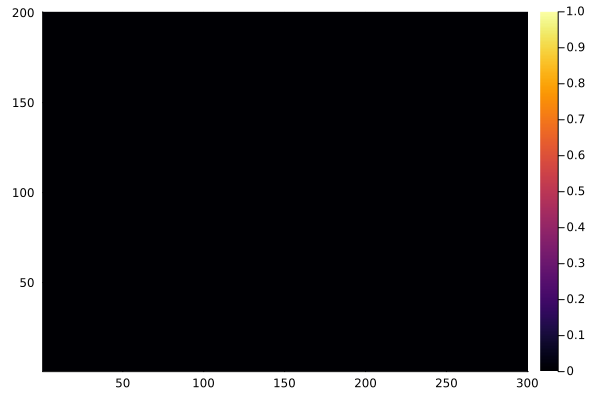

In [165]:
ready_3 = noisy_apollon
# m = Array{AbstractFloat}(undef, 10)

for i in range(1, 10)
    thres = 0.2 * (1 - i * 1 / 10)^2
    grandpa_3 = fft(ready_3)
    my_mask_3 = masker(grandpa_3, thres=thres, mode="thres", verbose=false)
    ready_3 = remove_noise(grandpa_3, my_mask_3, window_2d)
    Plots.heatmap(ready_3)
    Plots.savefig("cleaned_image_" * string(i))
end    
    

Plots.heatmap(ready_3)
    

In [22]:
nov = 12.15 + 5.47 + 26.45 + 48.99 + 61.77 + 20.35 + 26 + 23.16 + 13.44 + 49.0 + 9.20 + 8.40 + 5.49 + 3.31 + 3.56
nov -= 150 + 200

-33.26000000000005

In [24]:
dez = 30 + 50 + 2.24 + 3.5 + 48.49 + 16.97 + 20 + 169.27 + 1.07 + 23.24 + 6.40 + 5.95 + 25.82
dez -= 150 + 350 - nov

-130.31

Vector{Float64}[66.49136724073398, 2.9280665516666655, 0.3415221452244451]
[66.49136724073398]


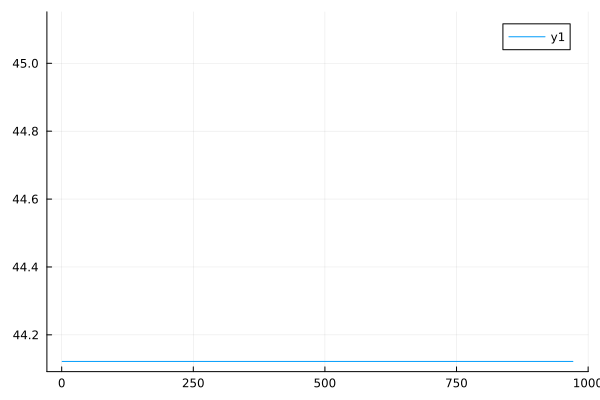

In [223]:
# fit_parameter_array should look like this: [[A, alpha, beta], [A, alpha, beta], ...]
# x: is it a single value or can it be an array?

function many_gammas(x, fit_parameter_array)
    all_gammas = zeros(length(x))
    fit_parameter_array = abs.(fit_parameter_array) # to avoid domain errors from the fit
    how_many_gammas = length(fit_parameter_array) / 3
    if round(how_many_gammas) != how_many_gammas
        println("many_gammas: number of parameters needs to be divisible by three.")
        how_many_gammas = 3
    end 
        
    start = 1
    for i in 1:Int(how_many_gammas)
        A = fit_parameter_array[start]
        alpha = fit_parameter_array[start+1]
        beta = fit_parameter_array[start+2]
        
        # println("A = ", A, " alpha = ", alpha, " beta = ", beta)
        
        gamma_now = Distributions.Gamma(alpha, beta)
        all_gammas +=  A * Distributions.pdf(gamma_now, x)
        
        start += 3
    end 
    
    return all_gammas
end 

function fit_with_gammas(fft_image; max_n_gammas=10, rel_reso=1000)
    abs_fft_image = abs.(fft_image)
    stepsize = length(abs_fft_image) / rel_reso
    fft_img_density = EasyFit.fitdensity(vec(abs_fft_image), step=stepsize, norm=0)
    fft_img_hist = StatsBase.fit(Histogram, grabs_values, nbins=rel_reso)
    
    # should you norm the density distribution, eg to its max??
    x_edges = fft_img_hist.edges[1] # vcat([0.1], fft_img_hist.edges[2:length(fft_img_hist.edges)]) # fft_img_density.x
    y_data = fft_img_hist.weights # fft_img_density.d
    
    x_data = zeros(size(y_data))
    for i in 1:length(x_edges)-1
        x_data[i] = (x_edges[i+1] - x_edges[i])
    end
    x_data_normed = vec(x_data ./ maximum(x_data)) # x_data will all be positive.
    
    print(typeof(x_data_normed))
    
    for n_gamma in 1:Int(ceil(max_n_gammas))
        # define the distribution with some good inital parameters
        # feed it into LSQ fit
        
        # check how good the fit was
        # save the parameters
    end 
    # choose best parameters in between
    
    # for now: just do a fit with three gamma functions
    # LsqFit.curve_fit(model_function, x_data, y_data, inital_parameters)
    initial_param = vec([10.0, 1.0, 0.5])
    fit = LsqFit.curve_fit(many_gammas, x_data_normed, y_data, initial_param)
    println(fit.param)
    # println(LsqFit.estimate_cov(fit))
    
    # check if the biggest part of your gamma functions is similar to a Gaussian, 
    # and check for the threshold where the tail diverges.
    
    
    n_gammas = 1; final_parameters = abs.(fit.param)
    how_many_param = length(final_parameters)
    
    # apply a cut already?
    cut_threshold = 1 * maximum(x_data)
    # look at the different components
    As = final_parameters[1:3:how_many_param-2]
    alphas = final_parameters[2:3:how_many_param-1]
    betas = final_parameters[3:3:how_many_param]
    
    println(As)
    
    return x_data_normed, final_parameters, n_gammas
end 

new_x, final_parameters, n_gammas = fit_with_gammas(grandpa, rel_reso=1000)

dd = Distributions.Gamma(1.2, 0.2)

rango_x = collect(0:0.01:5.0)

dd2 = many_gammas(new_x, final_parameters)

# data = pdf(dd, rango_x)
# Plots.plot(rango_x, dd2)
Plots.plot(dd2)

In [221]:
new_x



971-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [222]:
dd2



971-element Vector{Float64}:
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
  ⋮
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534
 44.12170352881534

In [3]:
cos( 68.0 * 1.3 * 0.010)^6

0.06498226977926291

In [4]:
29 - 14 + 17 + 31 + 30 + 31 + 30 + 31

185

In [5]:
185 * 2

370